# Graph attention network (GAT) for node classification

**Author:** [akensert](https://github.com/akensert)<br>
**Date created:** 2021/09/13<br>
**Last modified:** 2021/12/26<br>
**Description:** An implementation of a Graph Attention Network (GAT) for node classification.

Update (19 Jul 2022):
Additional GCN code, additional self-links to edge graphs,
more comments, diagrams and cell blocks added to help understand the code better by John Tan Chong Min.

## Introduction

[Graph neural networks](https://en.wikipedia.org/wiki/Graph_neural_network)
is the prefered neural network architecture for processing data structured as
graphs (for example, social networks or molecule structures), yielding
better results than fully-connected networks or convolutional networks.

In this tutorial, we will implement a specific graph neural network known as a
[Graph Attention Network](https://arxiv.org/abs/1710.10903) (GAT) to predict labels of
scientific papers based on what type of papers cite them (using the
[Cora](https://linqs.soe.ucsc.edu/data) dataset).

### References

For more information on GAT, see the original paper
[Graph Attention Networks](https://arxiv.org/abs/1710.10903) as well as
[DGL's Graph Attention Networks](https://docs.dgl.ai/en/0.4.x/tutorials/models/1_gnn/9_gat.html)
documentation.

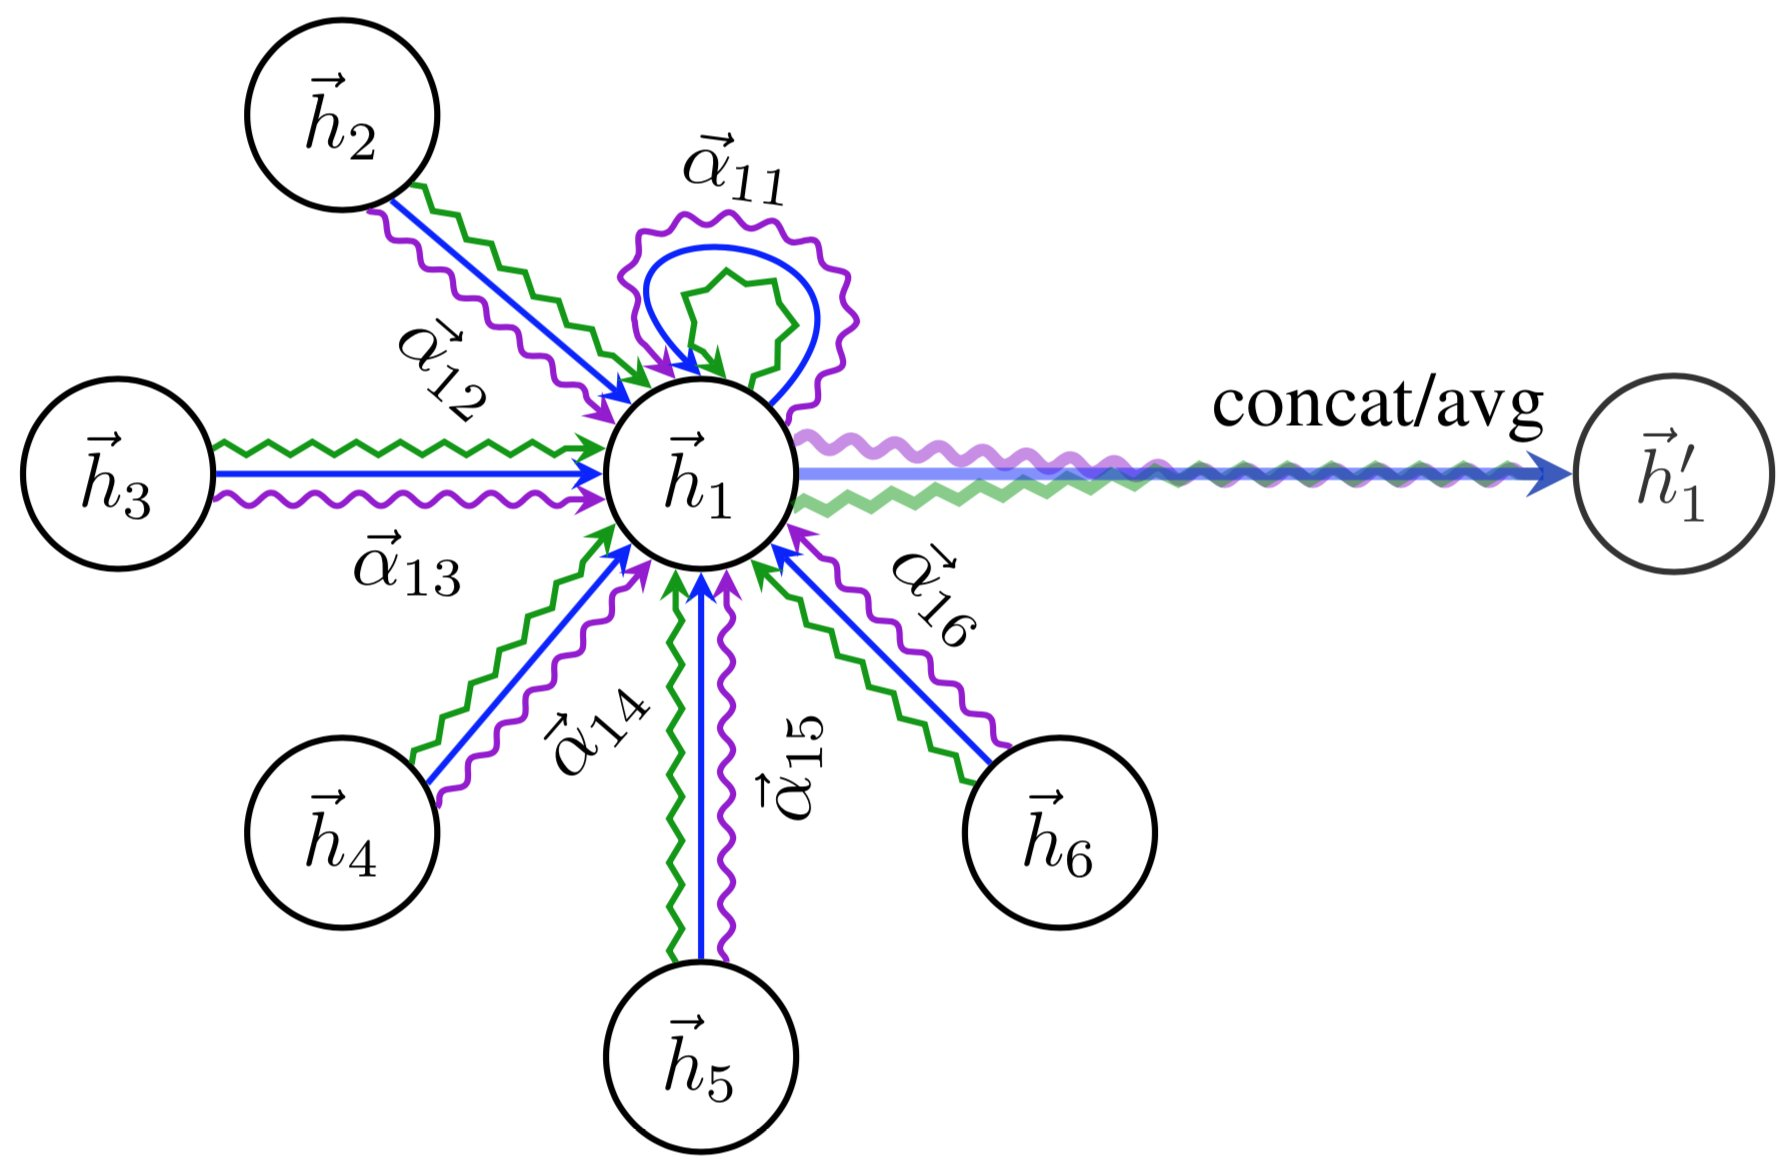

In [ ]:
from IPython import display
display.Image("https://mila.quebec/wp-content/uploads/2018/07/687474703a2f2f7777772e636c2e63616d2e61632e756b2f25374570763237332f696d616765732f6761742e6a7067.jpeg",
              width = 600)

### Import packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 6)
np.random.seed(2)

## Obtain the dataset

The preparation of the [Cora dataset](https://linqs.soe.ucsc.edu/data) follows that of the
[Node classification with Graph Neural Networks](https://keras.io/examples/graph/gnn_citations/)
tutorial. Refer to this tutorial for more details on the dataset and exploratory data analysis.
In brief, the Cora dataset consists of two files: `cora.cites` which contains *directed links* (citations) between
papers; and `cora.content` which contains *features* of the corresponding papers and one
of seven labels (the *subject* of the paper).

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)

data_dir = os.path.join(os.path.dirname(zip_file), "cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)

class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

print(citations)

print(papers)

      target  source
0          0      21
1          0     905
2          0     906
...      ...     ...
5426    1874    2586
5427    1876    1874
5428    1897    2707

[5429 rows x 2 columns]
      paper_id  term_0  term_1  ...  term_1431  term_1432  subject
0          462       0       0  ...          0          0        2
1         1911       0       0  ...          0          0        5
2         2002       0       0  ...          0          0        4
...        ...     ...     ...  ...        ...        ...      ...
2705      2372       0       0  ...          0          0        1
2706       955       0       0  ...          0          0        0
2707       376       0       0  ...          0          0        2

[2708 rows x 1435 columns]


In [ ]:
citations

,target,source
0,0,21
1,0,905
2,0,906
...,...,...
5426,1874,2586
5427,1876,1874
5428,1897,2707


(array([1.143e+03, 0.000e+00, 6.190e+02, 0.000e+00, 3.490e+02, 0.000e+00,
        1.840e+02, 0.000e+00, 1.050e+02, 0.000e+00, 9.300e+01, 0.000e+00,
        4.800e+01, 0.000e+00, 3.000e+01, 0.000e+00, 2.900e+01, 0.000e+00,
        2.300e+01, 0.000e+00, 1.000e+01, 0.000e+00, 1.300e+01, 0.000e+00,
        7.000e+00, 0.000e+00, 7.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        7.000e+00, 0.000e+00, 5.000e+00, 0.000e+00, 4.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 6.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

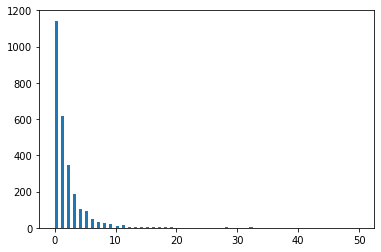

In [ ]:
# Show the number of citations each paper has
plt.hist([len(citations[citations['target']==j]) for j in range(len(papers))], bins = 100, range = (0, 50))

### Split the dataset

In [ ]:
# Obtain random indices
random_indices = np.random.permutation(range(papers.shape[0]))

# 50/50 split
train_data = papers.iloc[random_indices[: len(random_indices) // 2]]
test_data = papers.iloc[random_indices[len(random_indices) // 2 :]]

In [ ]:
train_data

,paper_id,term_0,term_1,...,term_1431,term_1432,subject
1415,2226,0,0,...,0,0,3
839,1578,0,0,...,0,0,2
157,379,0,0,...,0,0,6
...,...,...,...,...,...,...,...
1737,954,1,0,...,0,0,1
1005,1463,0,0,...,0,0,2
1784,1589,0,0,...,0,0,1


### Prepare the graph data

In [ ]:
# Obtain paper indices which will be used to gather node states
# from the graph later on when training the model
train_indices = train_data["paper_id"].to_numpy()
test_indices = test_data["paper_id"].to_numpy()

# Obtain ground truth labels corresponding to each paper_id
train_labels = train_data["subject"].to_numpy()
test_labels = test_data["subject"].to_numpy()

# Define graph, namely an edge tensor and a node feature tensor
edges = tf.convert_to_tensor(citations[["target", "source"]])
node_states = tf.convert_to_tensor(papers.sort_values("paper_id").iloc[:, 1:-1])

# Print shapes of the graph
print("Edges shape:\t\t", edges.shape)
print("Node features shape:", node_states.shape)

Edges shape:		 (5429, 2)
Node features shape: (2708, 1433)


In [ ]:
train_data['subject'].to_numpy()

array([3, 2, 6, ..., 1, 2, 1])

In [ ]:
edges

<tf.Tensor: shape=(5429, 2), dtype=int64, numpy=
array([[   0,   21],
       [   0,  905],
       [   0,  906],
       ...,
       [1874, 2586],
       [1876, 1874],
       [1897, 2707]])>

In [ ]:
node_states

<tf.Tensor: shape=(2708, 1433), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>

## Build the model

GAT takes as input a graph (namely an edge tensor and a node feature tensor) and
outputs \[updated\] node states. The node states are, for each target node, neighborhood
aggregated information of *N*-hops (where *N* is decided by the number of layers of the
GAT). Importantly, in contrast to the
[graph convolutional network](https://arxiv.org/abs/1609.02907) (GCN)
the GAT makes use of attention machanisms
to aggregate information from neighboring nodes (or *source nodes*). In other words, instead of simply
averaging/summing node states from source nodes (*source papers*) to the target node (*target papers*),
GAT first applies normalized attention scores to each source node state and then sums.

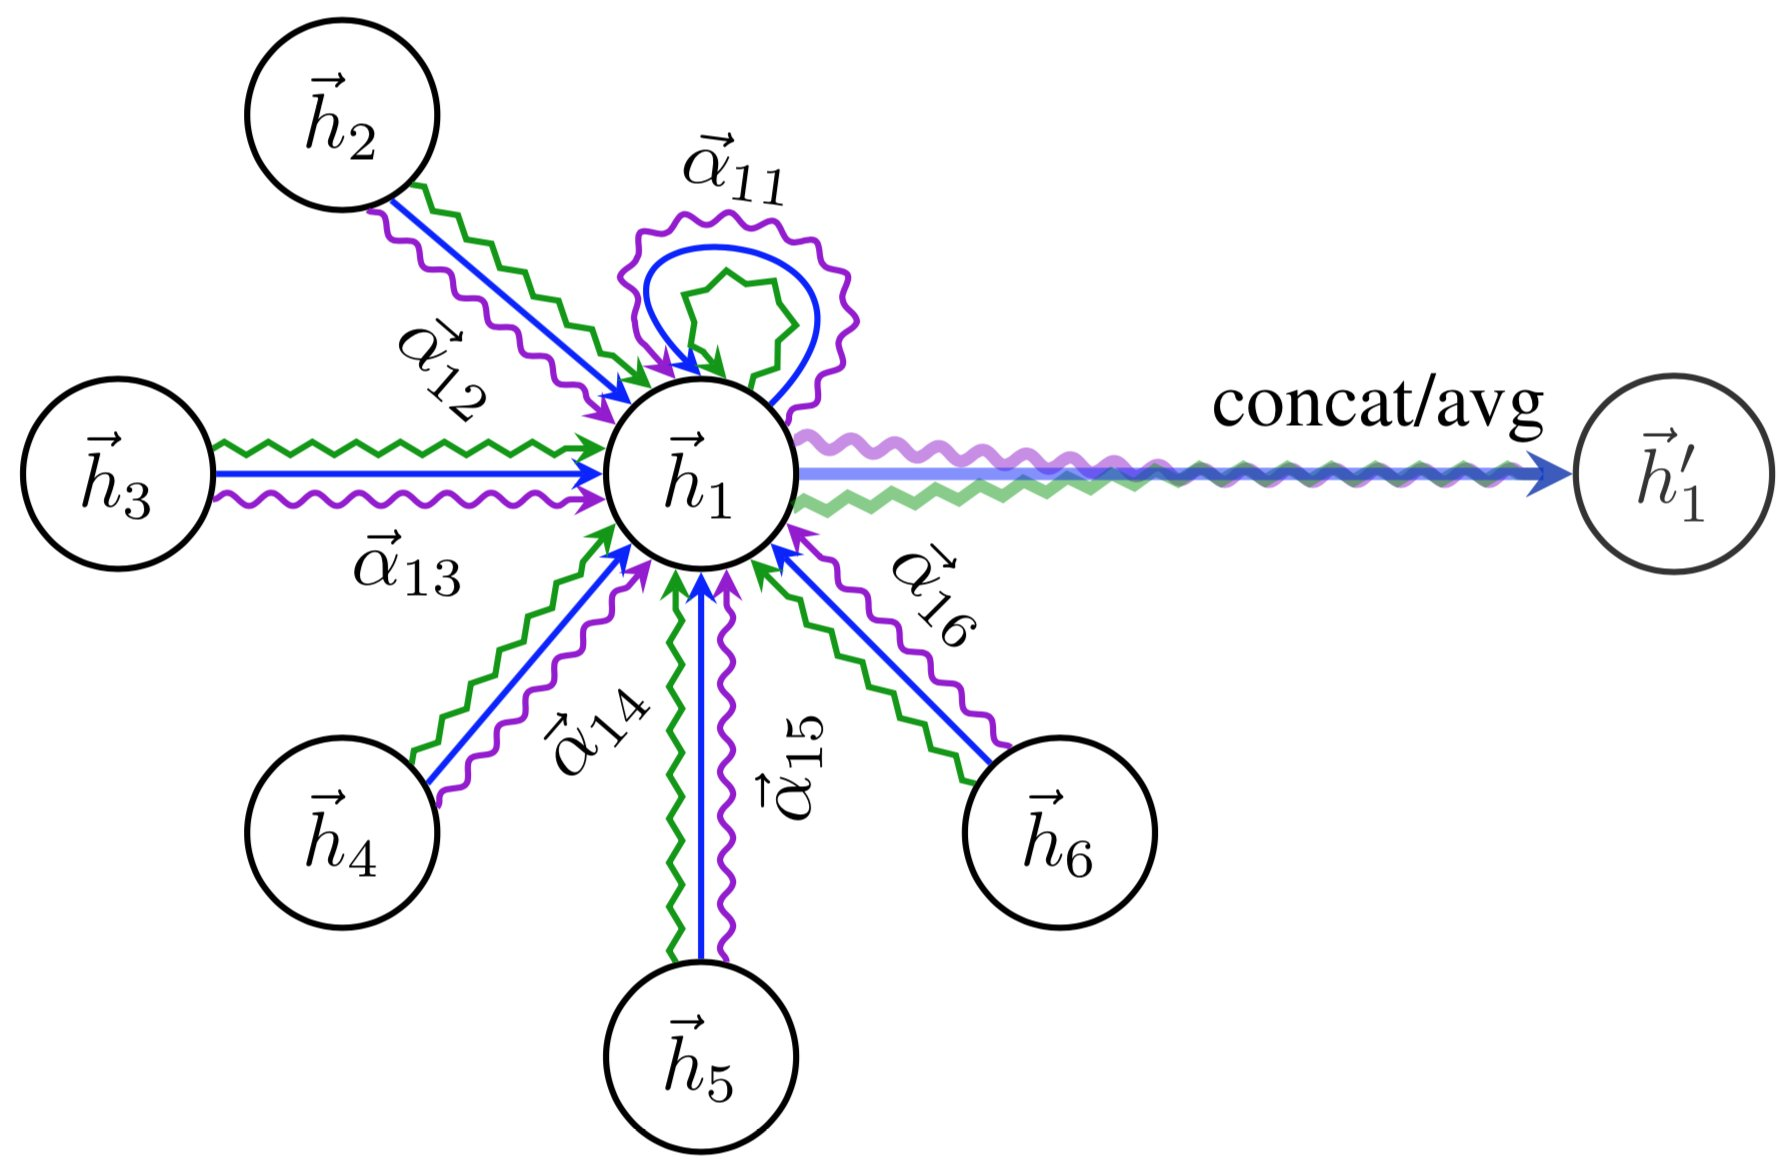

In [ ]:
from IPython import display
display.Image("https://mila.quebec/wp-content/uploads/2018/07/687474703a2f2f7777772e636c2e63616d2e61632e756b2f25374570763237332f696d616765732f6761742e6a7067.jpeg",
              width = 600)

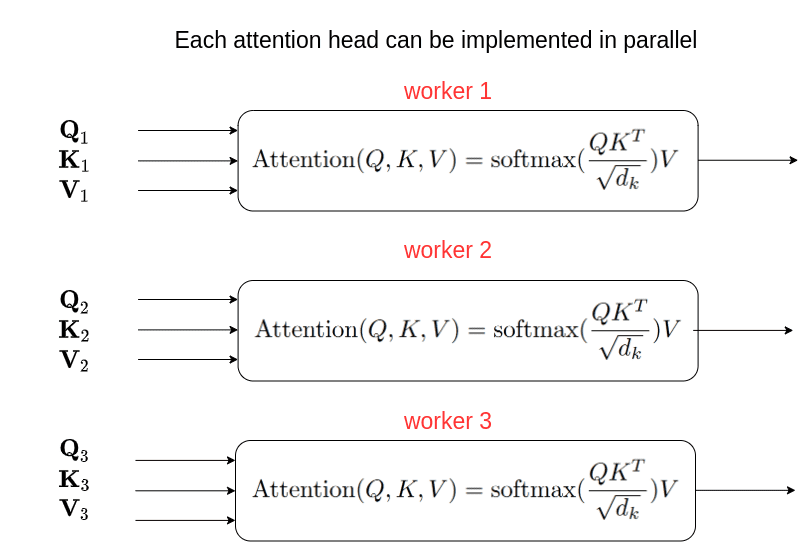

In [ ]:
display.Image("https://theaisummer.com/static/159ccc4fea2cef811b570d55cb594992/d2a60/multi-head-self-attention-block-diagram.png",
              width = 600)

### (Multi-head) graph attention layer

The GAT model implements multi-head graph attention layers. The `MultiHeadGraphAttention`
layer is simply a concatenation (or averaging) of multiple graph attention layers
(`GraphAttention`), each with separate learnable weights `W`. The `GraphAttention` layer
does the following:

Consider inputs node states `h^{l}` which are linearly transformed by `W^{l}`, resulting in `z^{l}`.

For each target node:

1. Computes pair-wise attention scores `a^{l}^{T}(z^{l}_{i}||z^{l}_{j})` for all `j`,
resulting in `e_{ij}` (for all `j`).
`||` denotes a concatenation, `_{i}` corresponds to the target node, and `_{j}`
corresponds to a given 1-hop neighbor/source node.
2. Normalizes `e_{ij}` via softmax, so as the sum of incoming edges' attention scores
to the target node (`sum_{k}{e_{norm}_{ik}}`) will add up to 1.
3. Applies attention scores `e_{norm}_{ij}` to `z_{j}`
and adds it to the new target node state `h^{l+1}_{i}`, for all `j`.

In [ ]:
# this gathers the respective indices of the original array into a new array
tf.gather([[0, 3, 5, 3], [1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3], [4, 4, 4, 4],
           [5, 5, 5, 5]], [[2, 3], [3, 5], [4, 5]])

<tf.Tensor: shape=(3, 2, 4), dtype=int32, numpy=
array([[[2, 2, 2, 2],
        [3, 3, 3, 3]],

       [[3, 3, 3, 3],
        [5, 5, 5, 5]],

       [[4, 4, 4, 4],
        [5, 5, 5, 5]]], dtype=int32)>

In [ ]:
c = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# this adds up the earlier array based on segment number defined below
tf.math.unsorted_segment_sum(c, [4, 2, 5, 5, 5, 5, 3, 2, 1, 0], num_segments=10).numpy()

array([ 9,  8,  8,  6,  0, 14,  0,  0,  0,  0], dtype=int32)

In [ ]:
d = [i for i in range(tf.reduce_max(edges[:, 0]) + 1)]
print('Original array:\n', d)
# this counts the number of occurences of each number in the original array
print('Number of edges referring to target node:\n', tf.math.bincount(tf.cast(edges[:, 0], "int32")))
# this repeats the original array by the number of repeats
repeated = tf.repeat(d, tf.math.bincount(tf.cast(edges[:, 0], "int32")))
print('Repeated original array:\n', repeated)
print('Number of occurences of each node in repeated array:\n', tf.math.bincount(repeated))

Original array:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 21

In [ ]:
class GraphAttention(layers.Layer):
    def __init__(
        self,
        units,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            # (800, 100)
            shape=(input_shape[0][-1], self.units),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel",
        )
        self.kernel_attention = self.add_weight(
            # (200, 1)
            shape=(self.units * 2, 1),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel_attention",
        )
        self.built = True

    def call(self, inputs):
        node_states, edges = inputs

        # Linearly transform node states to hidden representation dimension of 100

        # node_states is of dimension: node_num * 800
        # self.kernel is of dimension: 800 * 100
        # matmul output will be of the dimension: node_num * 100

        # node_states is (2708, 800)
        # edges is (5429, 2)
        # node_states_transformed is (2708, 100)
        # Matrix Multiplication of HW
        node_states_transformed = tf.matmul(node_states, self.kernel)
        
        # (1) Compute pair-wise attention scores
        # node_states_expanded concatenates the hidden representation of both nodes present in the edge pair
        # node_states_expanded shape is (5429, 2, 100)
        node_states_expanded = tf.gather(node_states_transformed, edges)

        # reshape it to make it (5429, 200)
        node_states_expanded = tf.reshape(
            node_states_expanded, (tf.shape(edges)[0], -1)
        )

        # nodes_states_expanded shape is (5429, 200)
        # kernel_attention shape is (200, 1)
        # attention_scores shape is (5429, 1)
        attention_scores = tf.nn.leaky_relu(
            tf.matmul(node_states_expanded, self.kernel_attention)
        )
        # attention_scores shape is (5429, )
        attention_scores = tf.squeeze(attention_scores, -1)

        # (2) Normalize attention scores
        # does the softmax, but clips the exponent between -2 and 2 to prevent gradient overflow/underflow
        attention_scores = tf.math.exp(tf.clip_by_value(attention_scores, -2, 2))

        # sum up the attention scores of only the target nodes
        # the segments are labelled by target nodes, and each segment will be the total sum of all the different 
        # components with the same label
        # the number of segments is just the total number of target nodes
        attention_scores_sum = tf.math.unsorted_segment_sum(
            data=attention_scores,
            segment_ids=edges[:, 0],
            num_segments=tf.reduce_max(edges[:, 0]) + 1,
        )

        # attention_socres repeated by number of nodes linked to target node
        node_count = tf.math.bincount(tf.cast(edges[:, 0], "int32"))
        attention_scores_sum = tf.repeat(attention_scores_sum, node_count)

        # total number of connected nodes for each node (only needed for GCN)
        connected_nodes = tf.repeat(node_count, node_count)
        connected_nodes = tf.cast(connected_nodes, "float32")

        # Each of the target nodes in attention_scores divided by the number of nodes linked to target node. Shape is (5429,)
        # For the neighbours of a given target node, the attention scores sum to 1
        # Shape is (5429,)
        attention_scores_norm = attention_scores / attention_scores_sum

        # (3) Gather node states of neighbors, apply attention scores and aggregate
        # node_states_neighbors shape is (5429, 100)
        # out shape is (2708, 100)

        # TODO: Uncomment one of the lines below to experiment with GAT / GCN / unnoramlized GCN
        # GAT performs the best, followed by GCN, then unnormalized GCN
        node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
        out = tf.math.unsorted_segment_sum(
            # data=node_states_neighbors * attention_scores_norm[:, tf.newaxis], # this is for GAT
            data=node_states_neighbors / connected_nodes[:, tf.newaxis], # this is for GCN
            # data=node_states_neighbors, # this is for unnoramlized GCN
            segment_ids=edges[:, 0],
            num_segments=tf.shape(node_states)[0],
        )
        return out


class MultiHeadGraphAttention(layers.Layer):
    def __init__(self, units, num_heads=8, merge_type="concat", **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.merge_type = merge_type
        self.attention_layers = [GraphAttention(units) for _ in range(num_heads)]

    def call(self, inputs):
        atom_features, pair_indices = inputs

        # Obtain outputs from each attention head
        outputs = [
            attention_layer([atom_features, pair_indices])
            for attention_layer in self.attention_layers
        ]
        # Concatenate or average the node states from each head
        if self.merge_type == "concat":
            outputs = tf.concat(outputs, axis=-1)
        else:
            outputs = tf.reduce_mean(tf.stack(outputs, axis=-1), axis=-1)
        # Activate and return node states
        return tf.nn.relu(outputs)


### Implement training logic with custom `train_step`, `test_step`, and `predict_step` methods

Notice, the GAT model operates on the entire graph (namely, `node_states` and
`edges`) in all phases (training, validation and testing). Hence, `node_states` and
`edges` are passed to the constructor of the `keras.Model` and used as attributes.
The difference between the phases are the indices (and labels), which gathers
certain outputs (`tf.gather(outputs, indices)`).

In [ ]:

class GraphAttentionNetwork(keras.Model):
    def __init__(
        self,
        node_states,
        edges,
        hidden_units,
        num_heads,
        num_layers,
        output_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.node_states = node_states
        self.edges = edges
        self.preprocess = layers.Dense(hidden_units * num_heads, activation="relu")
        self.attention_layers = [
            MultiHeadGraphAttention(hidden_units, num_heads) for _ in range(num_layers)
        ]
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        node_states, edges = inputs
        x = self.preprocess(node_states)
        for attention_layer in self.attention_layers:
            x = attention_layer([x, edges]) + x
        outputs = self.output_layer(x)
        return outputs

    def train_step(self, data):
        indices, labels = data

        with tf.GradientTape() as tape:
            # Forward pass
            outputs = self([self.node_states, self.edges])
            # Compute loss
            # tf.gather(outputs, indices) is an len(indices) * num_output_dimensions vector
            loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # Compute gradients
        grads = tape.gradient(loss, self.trainable_weights)
        # Apply gradients (update weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update metric(s)
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, data):
        indices = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # Compute probabilities
        return tf.nn.softmax(tf.gather(outputs, indices))

    def test_step(self, data):
        indices, labels = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # Compute loss
        loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # Update metric(s)
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}


### Train and evaluate

In [ ]:
# Define hyper-parameters
HIDDEN_UNITS = 100
NUM_HEADS = 8
NUM_LAYERS = 3
OUTPUT_DIM = len(class_values)

NUM_EPOCHS = 100
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 3e-1
MOMENTUM = 0.9

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(LEARNING_RATE, momentum=MOMENTUM)
accuracy_fn = keras.metrics.SparseCategoricalAccuracy(name="acc")
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_acc", min_delta=1e-5, patience=5, restore_best_weights=True
)

# Build model
# new_edges: Graph with only self-links to see how important the connections are
new_edges = tf.convert_to_tensor([[i, i] for i in range(len(edges))], dtype = "int64")
# TODO: Uncomment one of the lines below to do experiment with only one edge / full network
gat_model = GraphAttentionNetwork(
    # node_states, edges, HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM # for full edge network without self-links
    node_states, tf.concat([edges, new_edges], 0), HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM # for edge network with self-links
    # node_states, new_edges, HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM # for network with only self-links
)

# Compile model
gat_model.compile(loss=loss_fn, optimizer=optimizer, metrics=[accuracy_fn])

gat_model.fit(
    x=train_indices,
    y=train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping],
    verbose=2,
)

_, test_accuracy = gat_model.evaluate(x=test_indices, y=test_labels, verbose=0)

print("--" * 38 + f"\nTest Accuracy {test_accuracy*100:.1f}%")

Epoch 1/100


5/5 - 17s - loss: 3.4625 - acc: 0.1757 - val_loss: 2.1420 - val_acc: 0.1397 - 17s/epoch - 3s/step
Epoch 2/100
5/5 - 0s - loss: 1.8730 - acc: 0.2479 - val_loss: 1.6912 - val_acc: 0.3235 - 262ms/epoch - 52ms/step
Epoch 3/100
5/5 - 0s - loss: 1.5760 - acc: 0.4146 - val_loss: 1.2514 - val_acc: 0.5441 - 185ms/epoch - 37ms/step
Epoch 4/100
5/5 - 0s - loss: 1.1069 - acc: 0.6190 - val_loss: 0.9865 - val_acc: 0.7059 - 177ms/epoch - 35ms/step
Epoch 5/100
5/5 - 0s - loss: 0.6938 - acc: 0.7964 - val_loss: 0.8026 - val_acc: 0.7647 - 177ms/epoch - 35ms/step
Epoch 6/100
5/5 - 0s - loss: 0.4070 - acc: 0.8768 - val_loss: 0.8844 - val_acc: 0.7500 - 156ms/epoch - 31ms/step
Epoch 7/100
5/5 - 0s - loss: 0.2484 - acc: 0.9278 - val_loss: 0.8697 - val_acc: 0.7794 - 177ms/epoch - 35ms/step
Epoch 8/100
5/5 - 0s - loss: 0.1578 - acc: 0.9524 - val_loss: 0.9424 - val_acc: 0.7500 - 155ms/epoch - 31ms/step
Epoch 9/100
5/5 - 0s - loss: 0.1812 - acc: 0.9532 - val_loss: 0.9982 - val_acc: 0.8015 - 180ms/epoch - 36ms/ste

### Predict (probabilities)

In [ ]:
test_probs = gat_model.predict(x=test_indices)

mapping = {v: k for (k, v) in class_idx.items()}

for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Example {i+1}: {mapping[label]}")
    for j, c in zip(probs, class_idx.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---" * 20)

Example 1: Probabilistic_Methods
	Probability of Case_Based               =   0.042%
	Probability of Genetic_Algorithms       =   0.001%
	Probability of Neural_Networks          =   0.007%
	Probability of Probabilistic_Methods    =  99.654%
	Probability of Reinforcement_Learning   =   0.004%
	Probability of Rule_Learning            =   0.002%
	Probability of Theory                   =   0.291%
------------------------------------------------------------
Example 2: Genetic_Algorithms
	Probability of Case_Based               =   0.000%
	Probability of Genetic_Algorithms       =  99.984%
	Probability of Neural_Networks          =   0.000%
	Probability of Probabilistic_Methods    =   0.000%
	Probability of Reinforcement_Learning   =   0.015%
	Probability of Rule_Learning            =   0.001%
	Probability of Theory                   =   0.000%
------------------------------------------------------------
Example 3: Theory
	Probability of Case_Based               =   0.014%
	Probability of G

In [ ]:
# Visualize the sizes of each of the trainable variables in each layer

for layer in gat_model.layers:
  print(layer.name)
  for variable in layer.trainable_variables:
    print(variable.name, variable.shape)
  print()

dense_20
graph_attention_network_10/dense_20/kernel:0 (1433, 800)
graph_attention_network_10/dense_20/bias:0 (800,)

multi_head_graph_attention_30
graph_attention_network_10/multi_head_graph_attention_30/graph_attention_240/kernel:0 (800, 100)
graph_attention_network_10/multi_head_graph_attention_30/graph_attention_240/kernel_attention:0 (200, 1)
graph_attention_network_10/multi_head_graph_attention_30/graph_attention_241/kernel:0 (800, 100)
graph_attention_network_10/multi_head_graph_attention_30/graph_attention_241/kernel_attention:0 (200, 1)
graph_attention_network_10/multi_head_graph_attention_30/graph_attention_242/kernel:0 (800, 100)
graph_attention_network_10/multi_head_graph_attention_30/graph_attention_242/kernel_attention:0 (200, 1)
graph_attention_network_10/multi_head_graph_attention_30/graph_attention_243/kernel:0 (800, 100)
graph_attention_network_10/multi_head_graph_attention_30/graph_attention_243/kernel_attention:0 (200, 1)
graph_attention_network_10/multi_head_graph_a

## Conclusions

The results look OK! The GAT model seems to correctly predict the subjects of the papers,
based on what they cite, about 80% of the time. Further improvements could be
made by fine-tuning the hyper-parameters of the GAT. For instance, try changing the number of layers,
the number of hidden units, or the optimizer/learning rate; add regularization (e.g., dropout);
or modify the preprocessing step. We could also try to implement *self-loops*
(i.e., paper X cites paper X) and/or make the graph *undirected*.